In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Path for saving model
save_path = "/content/drive/MyDrive/CND_best_model.pth"
print("Drive mounted. Model will be saved to:", save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted. Model will be saved to: /content/drive/MyDrive/CND_best_model.pth


In [2]:
local_root = "/content/CND"
cancer_dir = os.path.join(local_root, "Cancer")
neuro_dir = os.path.join(local_root, "Neuro")

os.makedirs(cancer_dir, exist_ok=True)
os.makedirs(neuro_dir, exist_ok=True)

print("Local folders created.")

Local folders created.


In [3]:
import kagglehub
from pathlib import Path

raw_dir = Path(local_root) / "raw_downloads"
raw_dir.mkdir(parents=True, exist_ok=True)

print("Downloading datasets...")

# Cancer datasets
colon_path = kagglehub.dataset_download("orvile/coloncancerct-2025-abdominal-ct-scans")
breast_path = kagglehub.dataset_download("ambarish/breakhis")
lung_path  = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")

# Neurological datasets
alz_path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")
ms_path  = kagglehub.dataset_download("buraktaci/multiple-sclerosis")

print("All datasets downloaded.")

100%|██████████| 1.27G/1.27G [00:17<00:00, 78.3MB/s]

Extracting files...


Using Colab cache for faster access to the 'breakhis' dataset.


100%|██████████| 199M/199M [00:01<00:00, 123MB/s]

Extracting files...


100%|██████████| 71.5M/71.5M [00:00<00:00, 107MB/s]

Extracting files...


100%|██████████| 426M/426M [00:02<00:00, 211MB/s]

Extracting files...


All datasets downloaded.


In [4]:
import shutil
from tqdm import tqdm

def copy_images(src, dst):
    for root, _, files in os.walk(src):
        for f in tqdm(files, desc=f"Copying {os.path.basename(src)}"):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                src_path = os.path.join(root, f)
                dst_path = os.path.join(dst, f)
                try:
                    shutil.copy(src_path, dst_path)
                except:
                    pass

# Cancer datasets
copy_images(colon_path, cancer_dir)
copy_images(breast_path, cancer_dir)
copy_images(os.path.join(lung_path, "The IQ-OTHNCCD lung cancer dataset"), cancer_dir)

# Neurological datasets
copy_images(alz_path, neuro_dir)
copy_images(ms_path, neuro_dir)

print("All images copied successfully.")

Copying 1: 0it [00:00, ?it/s]
Copying 1: 100%|██████████| 1/1 [00:00<00:00, 14463.12it/s]
Copying 1: 0it [00:00, ?it/s]
Copying 1: 0it [00:00, ?it/s]
Copying 1: 0it [00:00, ?it/s]
Copying 1: 100%|██████████| 1020/1020 [00:00<00:00, 2381.86it/s]
Copying 1: 0it [00:00, ?it/s]
Copying 1: 100%|██████████| 4761/4761 [00:03<00:00, 1195.24it/s]
Copying 1: 0it [00:00, ?it/s]
Copying breakhis: 100%|██████████| 1/1 [00:00<00:00, 12122.27it/s]
Copying breakhis: 0it [00:00, ?it/s]
Copying breakhis: 0it [00:00, ?it/s]
Copying breakhis: 0it [00:00, ?it/s]
Copying breakhis: 100%|██████████| 6/6 [00:00<00:00, 35899.89it/s]
Copying breakhis: 0it [00:00, ?it/s]
Copying breakhis: 0it [00:00, ?it/s]
Copying breakhis: 0it [00:00, ?it/s]
Copying breakhis: 100%|██████████| 13/13 [00:00<00:00, 59.39it/s]
Copying breakhis: 0it [00:00, ?it/s]
Copying breakhis: 100%|██████████| 36/36 [00:00<00:00, 107.34it/s]
Copying breakhis: 0it [00:00, ?it/s]
Copying breakhis: 100%|██████████| 34/34 [00:00<00:00, 96.37it/s]
C

All images copied successfully.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
from tqdm import tqdm
import numpy as np
from google.colab import drive
import os

# --- Mount Drive ---
drive.mount('/content/drive')
save_dir = "/content/drive/MyDrive"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "CND_best_model.pth")
print("Model will be saved to:", save_path)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Model: Freeze feature extractor to prevent overfitting ---
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False  # freeze all layers

# Replace classifier
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # stronger dropout
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)
model = model.to(device)

# --- Loss & Optimizer ---
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)  # only train fc layer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model will be saved to: /content/drive/MyDrive/CND_best_model.pth
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os

# -----------------------------
# Data Transforms
# -----------------------------
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# -----------------------------
# Dataset Folders
# -----------------------------
def create_split_folders(base_dir):
    for split in ["train", "val", "test"]:
        for label in ["Cancer", "Neuro"]:
            os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

create_split_folders(local_root)

# -----------------------------
# Split images into train/val/test
# -----------------------------
from sklearn.model_selection import train_test_split
import shutil

def split_and_move_images(label_dir, label_name):
    images = glob.glob(os.path.join(label_dir, "*"))
    train, temp = train_test_split(images, test_size=0.3, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    splits = {"train": train, "val": val, "test": test}
    for split, files in splits.items():
        for f in tqdm(files, desc=f"Moving {label_name} {split}"):
            shutil.copy(f, os.path.join(local_root, split, label_name, os.path.basename(f)))

split_and_move_images(cancer_dir, "Cancer")
split_and_move_images(neuro_dir, "Neuro")
print("Dataset split into train/val/test.")

# -----------------------------
# Datasets & DataLoaders
# -----------------------------
train_data = datasets.ImageFolder(os.path.join(local_root, "train"), transform=train_transforms)
val_data   = datasets.ImageFolder(os.path.join(local_root, "val"), transform=val_test_transforms)
test_data  = datasets.ImageFolder(os.path.join(local_root, "test"), transform=val_test_transforms)

# Balanced sampling
class_counts = Counter([label for _, label in train_data.samples])
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = np.array([class_weights[label] for _, label in train_data.samples])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_data, batch_size=32, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

print("Data ready. Train:", len(train_data), "Val:", len(val_data), "Test:", len(test_data))
print("Class counts:", class_counts)

Moving Neuro test: 100%|██████████| 2103/2103 [00:00<00:00, 2807.23it/s]


Dataset split into train/val/test.
Data ready. Train: 20876 Val: 4473 Test: 4475
Class counts: Counter({0: 11065, 1: 9811})


In [8]:
num_epochs = 10
best_val_loss = np.inf
patience = 5
counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # --- Training ---
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        preds = (outputs>0.5).int()
        correct_train += (preds==labels.int()).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader.dataset)
    train_acc = correct_train/total_train

    # --- Validation ---
    model.eval()
    val_loss, correct_val, total_val = 0.0,0,0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validation"):
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = (outputs>0.5).int()
            correct_val += (preds==labels.int()).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val/total_val

    print(f"Train Loss:{train_loss:.4f} | Train Acc:{train_acc:.4f} | Val Loss:{val_loss:.4f} | Val Acc:{val_acc:.4f}")

    # --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, save_path)
        print("Model improved. Saved.")
        counter=0
    else:
        counter +=1
        if counter>=patience:
            print("Early stopping triggered.")
            break


Epoch 1/10


Validation: 100%|██████████| 140/140 [00:30<00:00,  4.56it/s]


Train Loss:0.1559 | Train Acc:0.9589 | Val Loss:0.1031 | Val Acc:0.9928
Model improved. Saved.

Epoch 2/10


Validation: 100%|██████████| 140/140 [00:30<00:00,  4.60it/s]


Train Loss:0.1056 | Train Acc:0.9727 | Val Loss:0.0797 | Val Acc:0.9944
Model improved. Saved.

Epoch 3/10


Validation: 100%|██████████| 140/140 [00:29<00:00,  4.69it/s]


Train Loss:0.0836 | Train Acc:0.9780 | Val Loss:0.0547 | Val Acc:0.9964
Model improved. Saved.

Epoch 4/10


Validation: 100%|██████████| 140/140 [00:29<00:00,  4.68it/s]


Train Loss:0.0710 | Train Acc:0.9810 | Val Loss:0.0423 | Val Acc:0.9969
Model improved. Saved.

Epoch 5/10


Validation: 100%|██████████| 140/140 [00:29<00:00,  4.71it/s]


Train Loss:0.0642 | Train Acc:0.9815 | Val Loss:0.0357 | Val Acc:0.9987
Model improved. Saved.

Epoch 6/10


Validation: 100%|██████████| 140/140 [00:30<00:00,  4.62it/s]


Train Loss:0.0596 | Train Acc:0.9834 | Val Loss:0.0276 | Val Acc:0.9987
Model improved. Saved.

Epoch 7/10


Training:   9%|▉         | 58/653 [00:18<03:06,  3.18it/s]


KeyboardInterrupt: 

Best model loaded for evaluation.


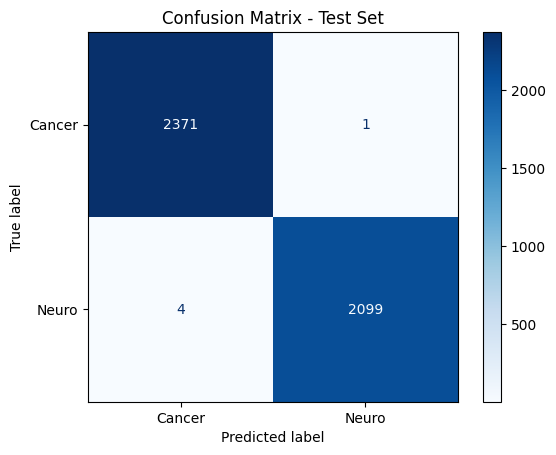

In [9]:
# Load best model
model.load_state_dict(torch.load(save_path))
model.eval()
print("Best model loaded for evaluation.")

# -----------------------------
# Confusion Matrix & Random Predictions
# -----------------------------
class_names = train_data.classes  # ['Cancer','Neuro']
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = (outputs.cpu()>0.5).int()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy().flatten())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

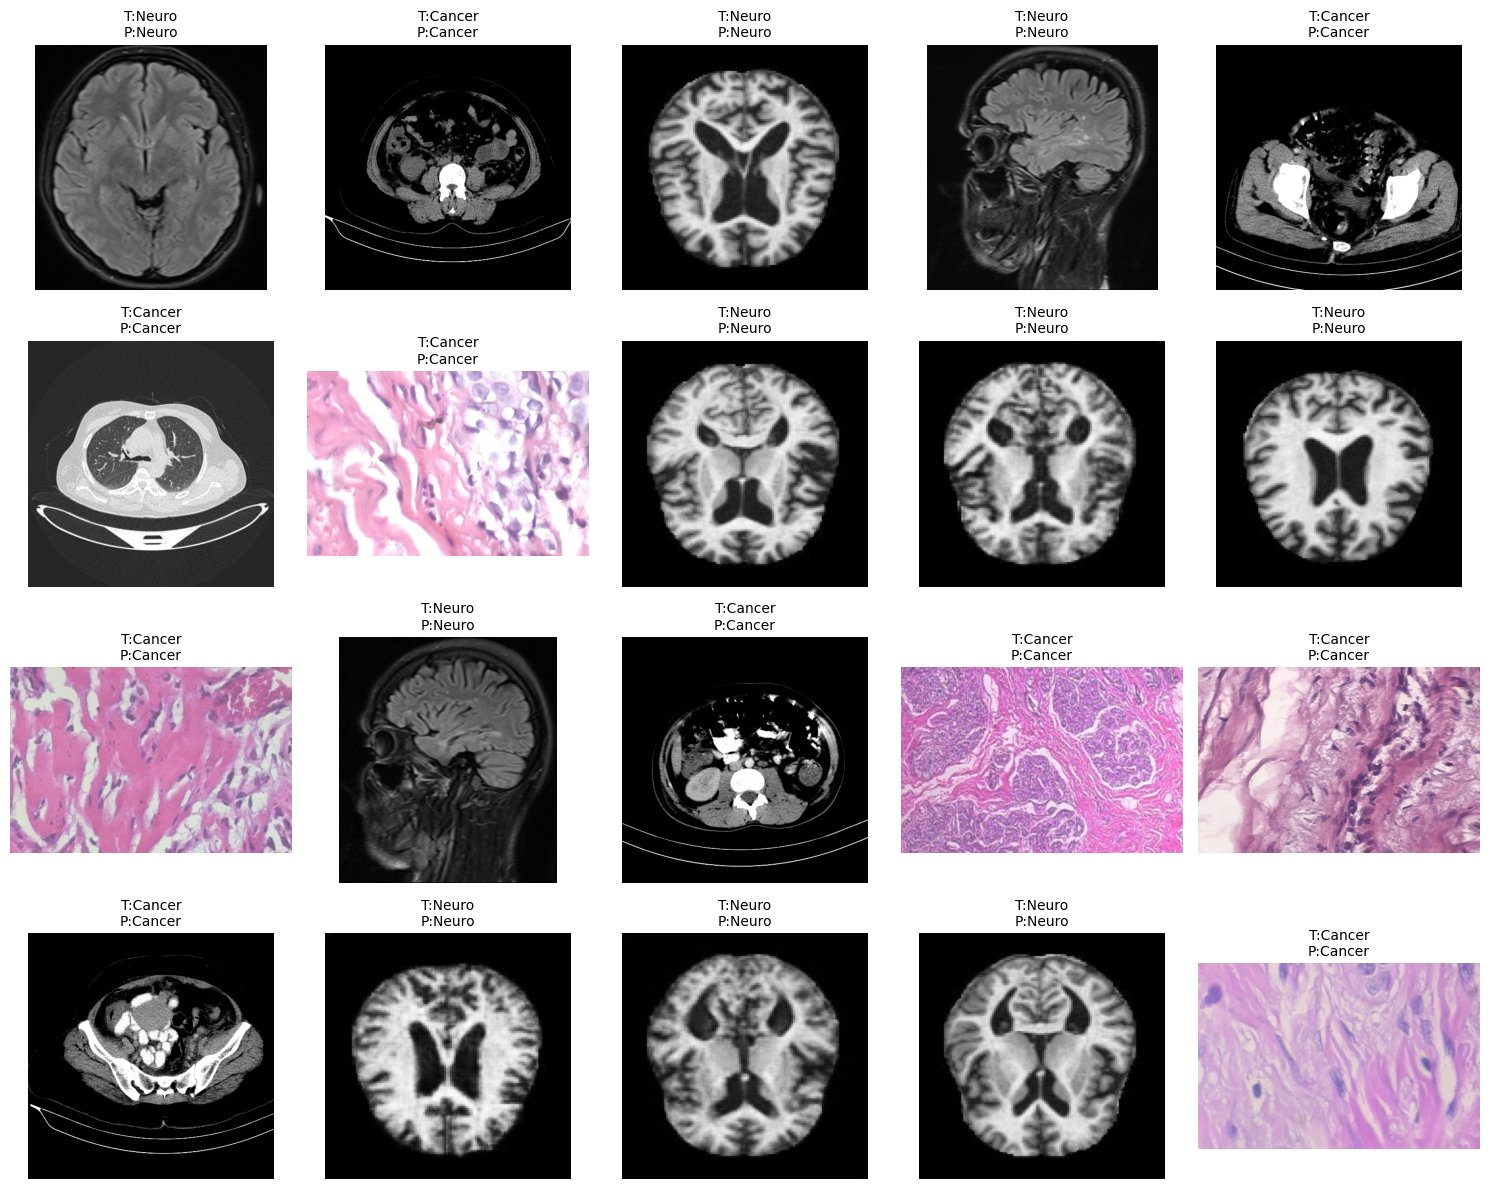

In [11]:
import os, random
import matplotlib.pyplot as plt
from PIL import Image
import torch

# --- Collect all test images ---
all_test_images = []
test_folder = os.path.join(local_root, "test")

for class_name in os.listdir(test_folder):
    class_path = os.path.join(test_folder, class_name)
    if not os.path.isdir(class_path):
        continue
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        all_test_images.append((img_path, class_name))

# --- Select 15–20 random images ---
random_images = random.sample(all_test_images, min(20, len(all_test_images)))

# --- Prediction setup ---
predict_transform = val_test_transforms  # same transform used for validation

# --- Create subplot grid ---
cols = 5
rows = (len(random_images) + cols - 1) // cols  # auto-calculate rows
plt.figure(figsize=(15, 3 * rows))

for idx, (img_path, true_label) in enumerate(random_images):
    image = Image.open(img_path).convert("RGB")
    tensor = predict_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        pred_label = class_names[int(output.item() > 0.5)]

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"T:{true_label}\nP:{pred_label}", fontsize=10)

plt.tight_layout()
plt.show()

Saving brain1.jpeg to brain1.jpeg


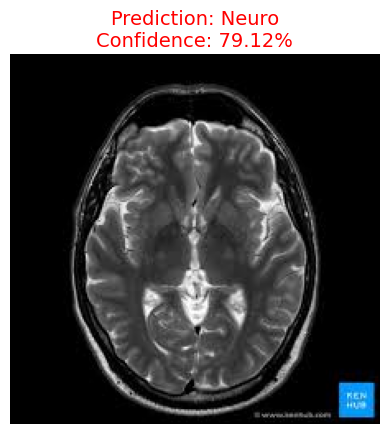

In [18]:
from google.colab import files
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# Upload an image from your PC
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")

    # Same normalization as used during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)   # model already has Sigmoid
        prob = output.item()         # single float between 0–1
        pred_idx = int(prob > 0.5)
        confidence = prob * 100 if pred_idx == 1 else (100 - prob * 100)
        label = class_names[pred_idx]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label}\nConfidence: {confidence:.2f}%",
              fontsize=14, color='red')
    plt.show()